In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [2]:
# Loading the cleaned dataset, in which within-mouse outliers have been removed and then the mean per mouse has been calculated
# Outlier biological replicates are still present.  Some mice are missing data for some proteins.
# (8/76 proteins are missing at least one data point.)
data = pd.read_csv('Data_Cortex_Nuclear_Means_Clean.csv')
data.replace(to_replace={'C/S': 'Learning', 'S/C': 'Control'}, inplace=True)
data.head()

,Genotype,Behavior,Treatment,class,Mouse,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,...,pGSK3B_Tyr216_N,SHH_N,BAD_N,BCL2_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N
0,Control,Learning,Memantine,c-CS-m,309,0.421063,0.576510,0.356447,2.278252,4.354744,...,0.832559,0.192871,0.151524,NaN,0.115433,0.423088,0.136374,0.169300,0.169590,1.674160
1,Control,Learning,Memantine,c-CS-m,311,0.600591,0.678479,0.334548,2.277561,4.234706,...,0.673229,0.188092,0.166315,0.168952,NaN,0.426774,0.141512,0.201386,0.200284,1.193285
2,Control,Learning,Memantine,c-CS-m,320,0.547676,0.796012,0.398649,2.664515,5.498960,...,0.859745,0.218300,0.159284,0.138537,0.123580,0.538909,0.141971,0.187006,NaN,1.624791
3,Control,Learning,Memantine,c-CS-m,321,0.438728,0.652045,0.359441,2.686405,5.298355,...,0.922949,0.238123,NaN,0.158817,NaN,0.559531,0.150542,0.220306,NaN,1.678225
4,Control,Learning,Memantine,c-CS-m,322,0.358931,0.512223,0.315105,2.111664,4.231444,...,0.828905,0.239495,NaN,0.154224,0.141323,0.493076,NaN,NaN,NaN,1.607234


In [3]:
all_proteins = data.columns[5:]

In [4]:
def anova_3way(protein):
    formula = protein + ' ~ C(Genotype) + C(Behavior) + C(Treatment)'
    formula += ' + C(Genotype):C(Behavior) + C(Genotype):C(Treatment) + C(Behavior):C(Treatment)'
    formula += ' + C(Genotype):C(Behavior):C(Treatment)'
    model = ols(formula, data).fit()
    aov_table = anova_lm(model, typ=2)
    return aov_table

In [5]:
a = anova_3way('NUMB_N')
effect_list = a.index[0:-1]
a

,sum_sq,df,F,PR(>F)
C(Genotype),0.000854,1.0,2.856319,0.095881
C(Behavior),0.004230,1.0,14.140658,0.000370
C(Treatment),0.003961,1.0,13.243647,0.000548
C(Genotype):C(Behavior),0.000225,1.0,0.753244,0.388694
C(Genotype):C(Treatment),0.000806,1.0,2.695760,0.105521
C(Behavior):C(Treatment),0.000206,1.0,0.687987,0.409933
C(Genotype):C(Behavior):C(Treatment),0.000664,1.0,2.220054,0.141140
Residual,0.019143,64.0,NaN,NaN


In [6]:
aov_results = pd.DataFrame(index = all_proteins,columns = effect_list)
for protein in all_proteins:
    aov_table = anova_3way(protein)
    aov_results.loc[protein] = aov_table['PR(>F)'][0:-1]
aov_results.columns = ['Genotype', 'Behavior', 'Treatment', 'Geno_Behav','Geno_Treat','Behav_Treat','Triple_Interact']
for c in aov_results.columns:
    aov_results[c] = pd.to_numeric(aov_results[c])
aov_results.sort_values('Geno_Behav')
aov_results.to_excel('AOV_Results.xls')

In [7]:
(aov_results < 0.05/76).sum()

Genotype            2
Behavior           32
Treatment           1
Geno_Behav          3
Geno_Treat          0
Behav_Treat         0
Triple_Interact     2
dtype: int64

Just as appeared from my clustering data, many proteins change levels with learning, but few have levels whose means are primarily affected by genotype or treatment.

In [8]:
#alpha = 0.05/76
alpha = 0.01
sig = aov_results.loc[(aov_results < alpha).sum(axis = 1) > 0]
(sig < alpha).sort_values(['Genotype','Treatment','Behavior'], ascending = False)

,Genotype,Behavior,Treatment,Geno_Behav,Geno_Treat,Behav_Treat,Triple_Interact
P38_N,True,True,True,False,False,False,False
S6_N,True,True,True,False,False,False,False
pNR2A_N,True,True,False,False,False,True,False
MTOR_N,True,True,False,True,False,False,False
APP_N,True,False,False,False,False,False,False
pMTOR_N,False,True,True,False,False,False,False
NUMB_N,False,True,True,False,False,False,False
pGSK3B_N,False,True,True,False,False,False,False
IL1B_N,False,True,True,False,False,False,False
Ubiquitin_N,False,True,True,False,False,False,False


Some logical connections: APP is known to be over-expressed in DS and is in fact on Chr. 21 
Mapping the effects to a interaction pathways would be helpful.
In particular many of these proteins are related to or regulated by mTOR signaling.
"postmortem studies of human AD brain reveal dysregulation in PTEN, Akt, S6K, and mTOR"

In [9]:
gb_interact = aov_results.Geno_Behav.sort_values()
candidates_gb = gb_interact.loc[gb_interact < 0.05].index

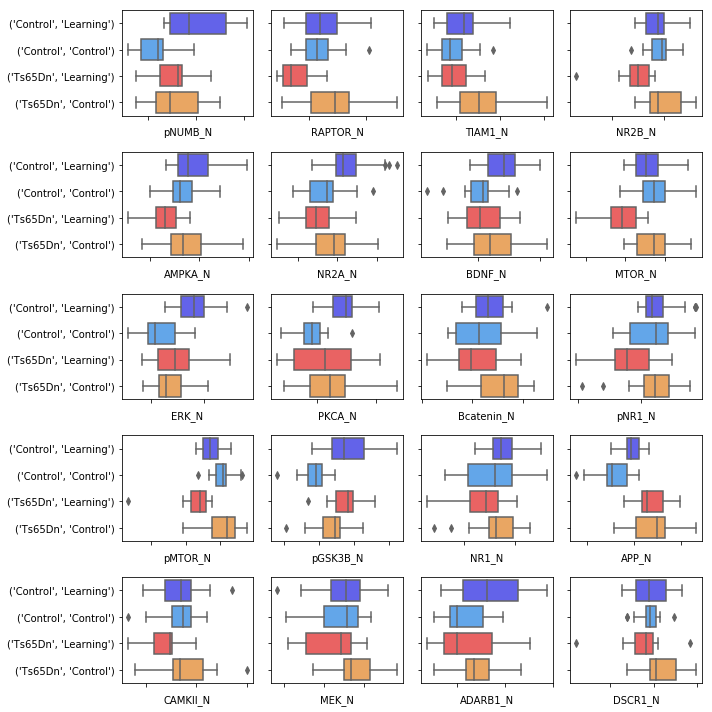

In [10]:
colors2 = [(0.3, 0.3,  1.0), #Control genotype, Learning = dark blue
          (0.3, 0.65, 1.0), #Control genotype, No learning = light blue
          (1.0, 0.3,  0.3), #Down Syndrome, Learning = red
          (1.0, 0.65, 0.3)] #Down Syndrome, No Learning = orange

_ = plt.figure(figsize = (10,10))
plot_idx = 1
v_axes = []
data_i = data.set_index(['Genotype', 'Behavior'])
for protein in candidates_gb:
    plt.subplot(5,4,plot_idx)
    v_axes.append(sns.boxplot(y = data_i.index, x = data_i[protein], palette = colors2, notch = False))
    v_axes[plot_idx-1].set(xticklabels=[])
    if (plot_idx % 4) != 1:
        v_axes[plot_idx-1].set(yticklabels=[])
    plot_idx += 1
_ = plt.tight_layout()

In [11]:
# Plot an interection plot for each protein to see effect of Genotype and Behavior,
# showing mean +/- SEM
def get_means_and_sems(variables):
    # variables is a list of column names.
    # groups data by variables and returns mean and S.E.M. dataframes
    means  = data.groupby(variables).mean()
    stds    = data.groupby(variables).std()
    counts = data.groupby(variables).count()
    sems   = stds / np.sqrt(counts)
    return means, sems

def interaction_plot(points, error_bars, protein, ind_order, axis):
    x_grouping    = points.index.names[ind_order[0]]
    line_grouping = points.index.names[ind_order[1]]
    point_vals = pd.pivot_table(data = points, 
                                values = protein, columns = x_grouping, index = line_grouping)
    error_vals = pd.pivot_table(data = error_bars, 
                                values = protein, columns = x_grouping, index = line_grouping)
    _ = point_vals.plot(yerr = error_vals, xlim = [-0.3,1.3], xticks = [0,1], ax = axis)
    _ = plt.title(protein)

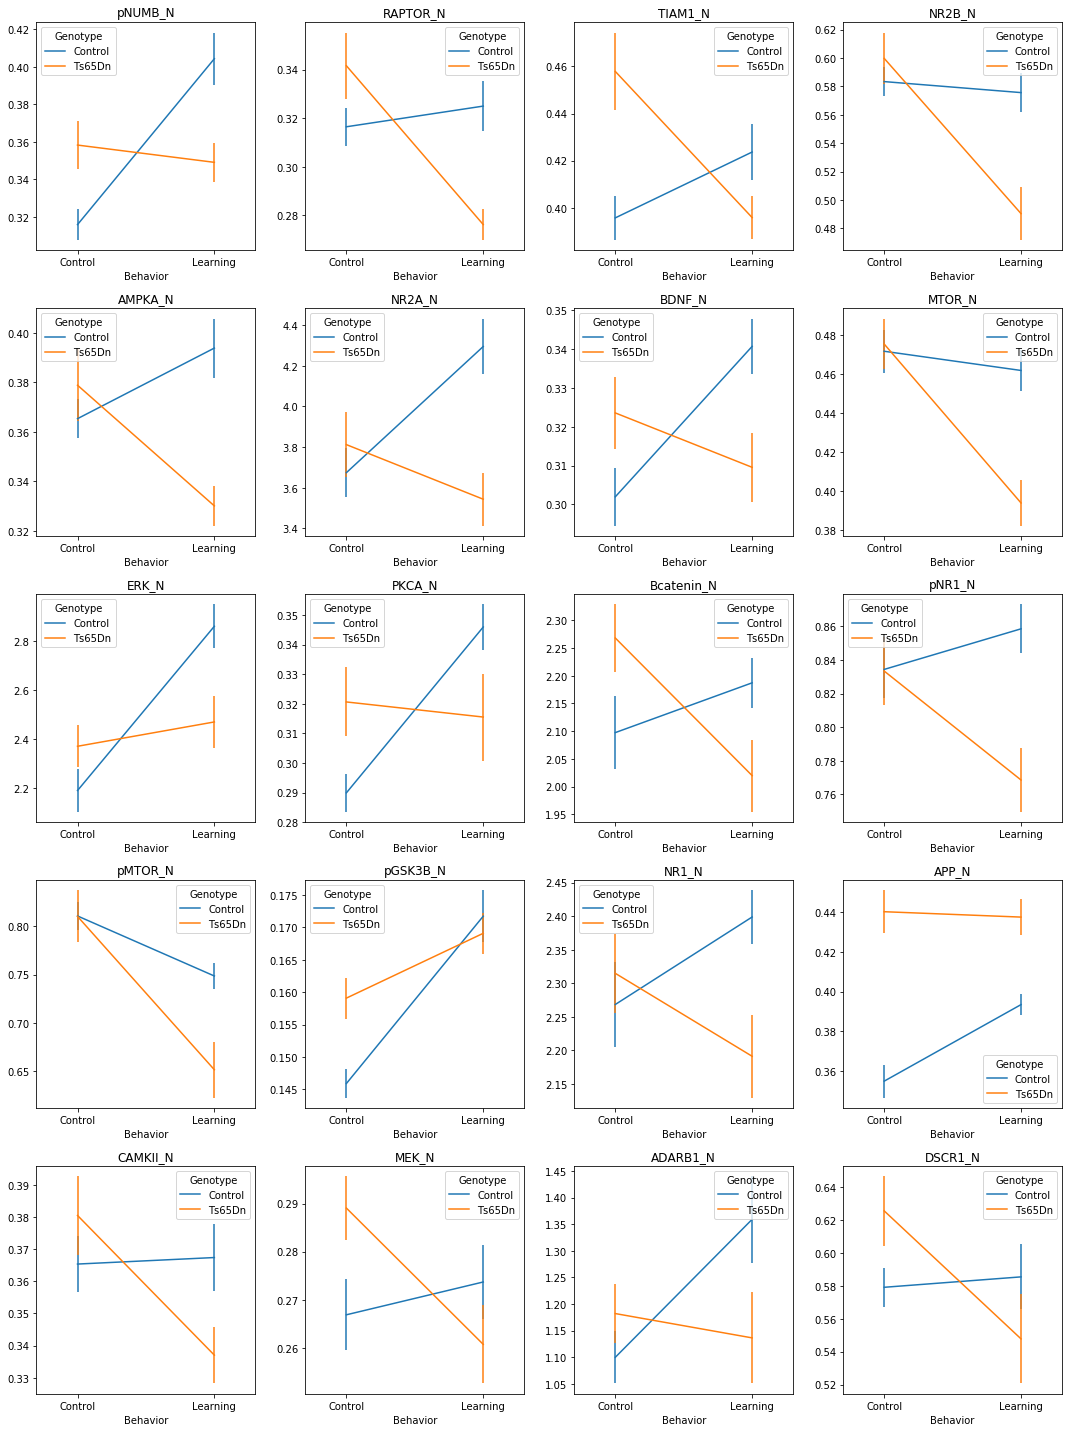

In [12]:
means, sems = get_means_and_sems(['Behavior','Genotype'])

_ = plt.figure(figsize = [15,20])
plot_idx = 1
for protein in candidates_gb:
    ax = plt.subplot(5,4,plot_idx)
    _ = interaction_plot(means, sems, protein, [1,0], ax)
    plot_idx += 1
_ = plt.tight_layout()

In [13]:
def multiple_comparison_correction(p_values, fdr = 0.05):
    # Given a numpy array of p-values and a desired false discovery rate,
    # uses the Benjamini–Hochberg procedure to correct for multiple comparisons.
    # Returns a boolean array where True indicates statistical significance of each
    # p-value and an array of the Q values that were used to compare the p-values.
    n_comparisons = len(p_values)
    p_ranks = stats.rankdata(p_values)
    q_values = p_ranks/n_comparisons*fdr
    cutoff = p_values[p_values < q_values]
    significant = np.asarray([False] * n_comparisons)
    if len(cutoff)>0:
        highest = max(cutoff)
        significant[p_values <= highest] = True
    return significant, q_values

In [14]:
sig, q_values = multiple_comparison_correction(gb_interact)
gb_interact_sig = pd.DataFrame({'p_value': gb_interact, 'significant': sig})

In [15]:
gb_interact_sig.loc[candidates_gb]

,p_value,significant
pNUMB_N,0.000093,True
RAPTOR_N,0.000490,True
TIAM1_N,0.000654,True
NR2B_N,0.000812,True
AMPKA_N,0.001096,True
NR2A_N,0.001493,True
BDNF_N,0.002321,True
MTOR_N,0.002322,True
ERK_N,0.002670,True
PKCA_N,0.004870,True
